# 🎓 Phase 1: 배경 지식

> **목표**: Decision Transformer를 이해하기 위한 **강화학습**과 **Transformer**의 기초 개념을 학습합니다.

---

## 📚 이 노트북에서 배우는 것

| 섹션 | 핵심 개념 | 왜 필요한가? |
|:---:|:---|:---|
| **1** | 강화학습 기초 | DT는 RL 문제를 푸는 모델이므로 |
| **2** | Transformer 기초 | DT의 핵심 아키텍처이므로 |
| **3** | 연습 문제 | 이해도 확인 |

---

## 🗺️ Decision Transformer 전체 그림

```mermaid
flowchart TB
    subgraph Traditional["🎮 기존 강화학습"]
        S1["상태 (State)"] -->|"이 상황에서 뭘 해야 해?"| A1["행동 (Action)"]
    end

    subgraph DT["🤖 Decision Transformer"]
        RTG["목표<br/>(RTG)"] --> TF["Transformer"]
        State["상태<br/>(State)"] --> TF
        TF -->|"100점을 얻으려면<br/>뭘 해야 해?"| Action["행동<br/>(Action)"]
    end

    style RTG fill:#e1f5fe,stroke:#01579b
    style State fill:#fff3e0,stroke:#e65100
    style Action fill:#e8f5e9,stroke:#1b5e20
    style TF fill:#f3e5f5,stroke:#4a148c
```

---

## 📋 목차

1. [🔧 환경 설정](#0-환경-설정)
2. [🎮 강화학습 기초](#1-강화학습-기초)
   - 핵심 용어 (State, Action, Reward)
   - Return과 Discount Factor
   - Policy (정책)
   - Trajectory (궤적)
3. [🤖 Transformer 기초](#2-transformer-기초)
   - Self-Attention 메커니즘
   - Causal Masking
   - Positional Encoding
   - Autoregressive 생성
4. [✏️ 연습 문제](#3-연습-문제)

---

# 🔧 0. 환경 설정

matplotlib에서 한글을 표시하려면 폰트 설정이 필요합니다.

> ⚠️ **참고**: 한글 폰트가 없어도 노트북 실행에는 문제 없습니다. 그래프 레이블만 영어로 표시됩니다.

In [4]:
# 한글 폰트 설정 및 기본 라이브러리 임포트
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
def setup_korean_font():
    """시스템에서 사용 가능한 한글 폰트를 찾아 설정"""
    # 자주 사용되는 한글 폰트 목록
    korean_fonts = [
        'NanumGothic', 'NanumBarunGothic', 'Malgun Gothic', 
        'AppleGothic', 'Noto Sans CJK KR', 'Noto Sans KR',
        'UnDotum', 'Baekmuk Gulim'
    ]
    
    # 시스템에 설치된 폰트 목록
    system_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # 사용 가능한 한글 폰트 찾기
    for font in korean_fonts:
        if font in system_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            print(f"Korean font set: {font}")
            return font
    
    # 한글 폰트를 찾지 못한 경우
    print("Warning: Korean font not found. Labels will be in English.")
    plt.rcParams['axes.unicode_minus'] = False
    return None

# 폰트 설정 실행
korean_font = setup_korean_font()

---

# 🎮 1. 강화학습 기초

## 1.1 핵심 용어

강화학습(Reinforcement Learning)은 **에이전트**가 **환경**과 상호작용하며 **보상**을 최대화하는 방법을 학습하는 분야입니다.

```mermaid
flowchart TB
    Agent["🤖 에이전트 (Agent)<br/><i>학습하는 주체</i><br/><small>예: 게임 플레이어</small>"]
    Env["🌍 환경 (Environment)<br/><i>상호작용 대상</i><br/><small>예: 게임 세계</small>"]

    Agent -->|"행동 (Action)"| Env
    Env -->|"상태 (State)"| Agent
    Env -->|"보상 (Reward)"| Agent

    style Agent fill:#bbdefb,stroke:#1565c0
    style Env fill:#c8e6c9,stroke:#2e7d32
```

### 📌 핵심 용어 정리

| 용어 | 영문 | 설명 | 게임 예시 |
|:---:|:---:|:---|:---|
| **상태** | State (s) | 환경의 현재 상황 | 게임 화면, 캐릭터 위치 |
| **행동** | Action (a) | 에이전트가 취하는 동작 | 점프, 이동, 공격 |
| **보상** | Reward (r) | 행동의 결과로 받는 피드백 | +10 (코인), -1 (피해) |
| **정책** | Policy (π) | 상태에서 행동을 선택하는 규칙 | "적이 보이면 공격" |
| **에피소드** | Episode | 시작부터 종료까지 한 번의 실행 | 게임 한 판 |

### 🎯 직관적 이해

> **비유**: 강화학습은 아이가 걷기를 배우는 것과 같습니다.
> - **상태**: 현재 자세 (서 있음, 넘어짐, 기울어짐)
> - **행동**: 다리를 움직이는 방식
> - **보상**: 성공적으로 한 걸음 (+1), 넘어짐 (-1)
> - **정책**: 어떤 자세에서 어떻게 다리를 움직일지에 대한 규칙

아래 코드에서 간단한 환경을 만들어 직접 확인해봅시다! 👇

In [5]:
# ============================================================================
# 🎮 간단한 그리드 월드 환경 만들기
# ============================================================================
# 
# 이 코드는 아주 간단한 1차원 게임 환경을 만듭니다.
# 
# 게임 규칙:
#   - 에이전트는 위치 0에서 시작
#   - 목표는 위치 5에 도달하는 것
#   - 행동: 왼쪽(0) 또는 오른쪽(1)으로 이동
#   - 보상: 목표 도달 시 +10, 그 외에는 -1
#
# 시각화:
#   시작                              목표
#     ↓                                 ↓
#   [ 0 ]---[ 1 ]---[ 2 ]---[ 3 ]---[ 4 ]---[ 5 ]
#     ●                                       ⭐
#
# ============================================================================

import random

class SimpleGridWorld:
    """
    간단한 1차원 그리드 월드 환경
    
    에이전트가 왼쪽/오른쪽으로 이동하여 목표 지점에 도달하는 게임입니다.
    """
    def __init__(self):
        self.position = 0  # 시작 위치
        self.goal = 5      # 목표 위치
        
    def reset(self):
        """에피소드 시작: 위치를 0으로 초기화"""
        self.position = 0
        return self.position  # 현재 상태(state) 반환
    
    def step(self, action):
        """
        한 스텝 실행: 행동을 받아서 환경을 업데이트
        
        Args:
            action: 0 = 왼쪽으로 이동, 1 = 오른쪽으로 이동
            
        Returns:
            state: 새로운 위치
            reward: 받은 보상
            done: 에피소드 종료 여부
        """
        # 행동에 따라 위치 변경
        if action == 0:  # 왼쪽
            self.position = max(0, self.position - 1)  # 0보다 작아지지 않도록
        else:  # 오른쪽
            self.position = min(self.goal, self.position + 1)  # 목표를 넘지 않도록
        
        # 보상 계산
        if self.position == self.goal:
            reward = 10   # 🎉 목표 도달! 큰 보상
            done = True   # 에피소드 종료
        else:
            reward = -1   # 😓 아직 도달 못함, 작은 페널티
            done = False  # 계속 진행
            
        return self.position, reward, done

# ============================================================================
# 🧪 환경 테스트하기
# ============================================================================

print("=" * 60)
print("🎮 그리드 월드 환경 테스트")
print("=" * 60)
print()

# 환경 생성 및 초기화
env = SimpleGridWorld()
state = env.reset()

print(f"📍 시작 상태: {state}")
print(f"🎯 목표 위치: {env.goal}")
print()
print("▶️ 오른쪽으로 계속 이동해봅시다!")
print("-" * 60)

# 오른쪽으로 계속 이동
total_reward = 0
for step in range(10):
    action = 1  # 오른쪽으로 이동
    state, reward, done = env.step(action)
    total_reward += reward
    
    # 현재 상태를 시각적으로 표시
    grid = ['[ ]'] * 6
    grid[state] = '[●]'  # 현재 위치 표시
    grid_str = '---'.join(grid)
    
    print(f"Step {step+1}: 행동={'→오른쪽':8s} | 위치={state} | 보상={reward:+3d} | {grid_str}")
    
    if done:
        print()
        print("🎉 목표 도달!")
        break

print()
print(f"📊 총 보상 (Return): {total_reward}")
print()
print("💡 해석: 5번 이동(-5)하고 목표 도달(+10) = 총 +6점")

🎮 그리드 월드 환경 테스트

📍 시작 상태: 0
🎯 목표 위치: 5

▶️ 오른쪽으로 계속 이동해봅시다!
------------------------------------------------------------
Step 1: 행동=→오른쪽     | 위치=1 | 보상= -1 | [ ]---[●]---[ ]---[ ]---[ ]---[ ]
Step 2: 행동=→오른쪽     | 위치=2 | 보상= -1 | [ ]---[ ]---[●]---[ ]---[ ]---[ ]
Step 3: 행동=→오른쪽     | 위치=3 | 보상= -1 | [ ]---[ ]---[ ]---[●]---[ ]---[ ]
Step 4: 행동=→오른쪽     | 위치=4 | 보상= -1 | [ ]---[ ]---[ ]---[ ]---[●]---[ ]
Step 5: 행동=→오른쪽     | 위치=5 | 보상=+10 | [ ]---[ ]---[ ]---[ ]---[ ]---[●]

🎉 목표 도달!

📊 총 보상 (Return): 6

💡 해석: 5번 이동(-5)하고 목표 도달(+10) = 총 +6점


---

## 1.2 Return과 Discount Factor

### 📖 Return (반환값)이란?

**Return**은 에피소드에서 얻은 **총 보상의 합**입니다. 기호로는 **G**로 표기합니다.

$$G_t = r_t + r_{t+1} + r_{t+2} + \cdots + r_T$$

> 💡 **쉽게 말하면**: "게임 한 판에서 얻은 총 점수"

---

### 🔢 Discount Factor (할인율)이란?

**할인율 γ(감마)**는 **미래 보상의 가치를 얼마나 낮출지** 결정하는 값입니다 (0 ~ 1 사이).

$$G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \cdots = \sum_{k=0}^{\infty} \gamma^k r_{t+k}$$

```
┌─────────────────────────────────────────────────────────────────────┐
│                     할인율(γ)의 의미                                │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│   γ = 1.0  →  "미래 보상도 지금만큼 중요해"                        │
│                미래 보상을 할인 없이 그대로 계산                    │
│                                                                     │
│   γ = 0.9  →  "미래 보상은 조금 덜 중요해" (일반적 설정)           │
│                10스텝 후 보상은 0.9^10 ≈ 0.35배로 할인              │
│                                                                     │
│   γ = 0.5  →  "가까운 미래만 신경 써"                              │
│                3스텝 후 보상은 0.5^3 = 0.125배로 할인               │
│                                                                     │
│   γ = 0.0  →  "지금 당장의 보상만 중요해"                          │
│                미래 보상은 완전히 무시                              │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### 🤔 왜 할인율을 사용하나요?

1. **수학적 안정성**: 무한히 긴 에피소드에서도 Return이 발산하지 않음
2. **현실 반영**: 지금 받는 1000원 vs 10년 후 받는 1000원 → 지금이 더 가치 있음
3. **불확실성**: 미래는 불확실하므로 현재 보상을 더 신뢰

아래 코드에서 직접 확인해봅시다! 👇

In [6]:
# ============================================================================
# 📊 Return 계산 예시
# ============================================================================
#
# 5개의 스텝에서 각각 [1, 2, 3, 4, 5]의 보상을 받았다고 가정합니다.
# 할인율(γ)에 따라 총 Return이 어떻게 달라지는지 확인해봅시다.
#
# ============================================================================

rewards = [1, 2, 3, 4, 5]  # 각 스텝의 보상

print("=" * 60)
print("📊 Return 계산 예시")
print("=" * 60)
print(f"\n보상 시퀀스: {rewards}")
print()

# ─────────────────────────────────────────────────────────────
# 1. 단순 Return (γ=1): 모든 보상을 그대로 합산
# ─────────────────────────────────────────────────────────────
simple_return = sum(rewards)
print(f"1️⃣ 단순 Return (γ=1): {rewards[0]} + {rewards[1]} + {rewards[2]} + {rewards[3]} + {rewards[4]} = {simple_return}")
print()

# ─────────────────────────────────────────────────────────────
# 2. Discounted Return: 미래 보상에 γ^t를 곱함
# ─────────────────────────────────────────────────────────────
def calculate_discounted_return(rewards, gamma):
    """
    할인된 Return 계산
    
    공식: G = r₀ + γ·r₁ + γ²·r₂ + γ³·r₃ + ...
    """
    discounted = 0
    for t, r in enumerate(rewards):
        discounted += (gamma ** t) * r  # γ^t × r_t
    return discounted

print("2️⃣ Discounted Return (다양한 γ 값):")
print("-" * 60)
print(f"{'γ':>6} | {'계산식':^35} | {'결과':>8}")
print("-" * 60)

for gamma in [0.0, 0.5, 0.9, 0.99, 1.0]:
    g = calculate_discounted_return(rewards, gamma)
    
    # 계산 과정 문자열 생성
    terms = [f"{gamma**i:.2f}×{r}" for i, r in enumerate(rewards[:3])]
    formula = " + ".join(terms) + " + ..."
    
    print(f"{gamma:>6.2f} | {formula:35} | {g:>8.2f}")

print()
print("💡 관찰:")
print("   - γ=0: 첫 번째 보상(1)만 계산됨")
print("   - γ=1: 모든 보상이 동일한 가치로 합산됨")
print("   - γ가 클수록 미래 보상도 중요하게 반영됨")

📊 Return 계산 예시

보상 시퀀스: [1, 2, 3, 4, 5]

1️⃣ 단순 Return (γ=1): 1 + 2 + 3 + 4 + 5 = 15

2️⃣ Discounted Return (다양한 γ 값):
------------------------------------------------------------
     γ |                 계산식                 |       결과
------------------------------------------------------------
  0.00 | 1.00×1 + 0.00×2 + 0.00×3 + ...      |     1.00
  0.50 | 1.00×1 + 0.50×2 + 0.25×3 + ...      |     3.56
  0.90 | 1.00×1 + 0.90×2 + 0.81×3 + ...      |    11.43
  0.99 | 1.00×1 + 0.99×2 + 0.98×3 + ...      |    14.60
  1.00 | 1.00×1 + 1.00×2 + 1.00×3 + ...      |    15.00

💡 관찰:
   - γ=0: 첫 번째 보상(1)만 계산됨
   - γ=1: 모든 보상이 동일한 가치로 합산됨
   - γ가 클수록 미래 보상도 중요하게 반영됨


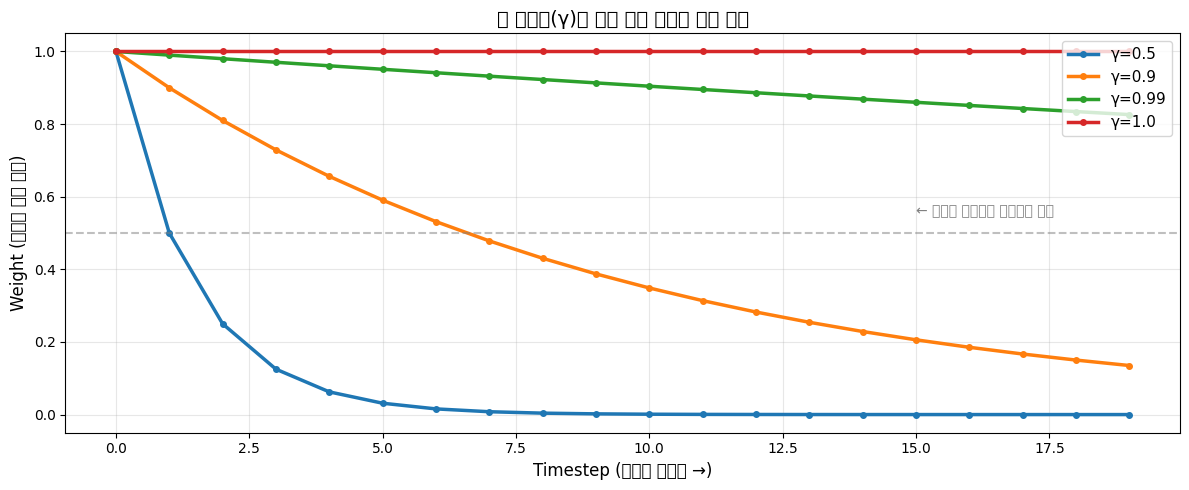


📖 그래프 해석:
• γ=1.0 (파란선): 미래 보상도 현재와 동일한 가치
• γ=0.99 (주황선): 매우 천천히 감소, 먼 미래도 중요
• γ=0.9 (초록선): 10스텝 후 보상은 약 35% 가치
• γ=0.5 (빨간선): 급격히 감소, 가까운 미래만 중요

💡 Decision Transformer에서는 주로 γ=1.0을 사용합니다!
   (할인 없이 순수 Return-to-Go를 사용)


In [7]:
# ============================================================================
# 📈 시각화: Discount Factor의 효과
# ============================================================================
#
# 이 그래프는 시간이 지남에 따라 보상의 "가치(weight)"가
# γ 값에 따라 어떻게 감소하는지 보여줍니다.
#
# Y축 값이 높을수록 해당 시점의 보상이 더 중요하게 반영됩니다.
#
# ============================================================================

import numpy as np

timesteps = np.arange(20)  # 0~19 스텝
gammas = [0.5, 0.9, 0.99, 1.0]  # 다양한 γ 값

plt.figure(figsize=(12, 5))

# 각 γ에 대해 weight 곡선 그리기
for gamma in gammas:
    weights = gamma ** timesteps  # γ^t 계산
    plt.plot(timesteps, weights, label=f'γ={gamma}', linewidth=2.5, marker='o', markersize=4)

# 그래프 꾸미기
plt.xlabel('Timestep (미래로 갈수록 →)', fontsize=12)
plt.ylabel('Weight (보상의 현재 가치)', fontsize=12)
plt.title('🔍 할인율(γ)에 따른 미래 보상의 가치 변화', fontsize=14)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)

# 설명 텍스트 추가
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.text(15, 0.55, '← 가치가 절반으로 감소하는 지점', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

# 해석 설명
print()
print("📖 그래프 해석:")
print("=" * 60)
print("• γ=1.0 (파란선): 미래 보상도 현재와 동일한 가치")
print("• γ=0.99 (주황선): 매우 천천히 감소, 먼 미래도 중요")
print("• γ=0.9 (초록선): 10스텝 후 보상은 약 35% 가치")
print("• γ=0.5 (빨간선): 급격히 감소, 가까운 미래만 중요")
print()
print("💡 Decision Transformer에서는 주로 γ=1.0을 사용합니다!")
print("   (할인 없이 순수 Return-to-Go를 사용)")

---

## 1.3 Policy (정책)

### 📖 Policy란?

**Policy π(a|s)**는 **"어떤 상태에서 어떤 행동을 할 것인가"**를 결정하는 규칙입니다.

> 💡 **쉽게 말하면**: "게임 공략집" 또는 "행동 매뉴얼"

---

### 🔀 두 가지 유형의 Policy

```mermaid
flowchart LR
    subgraph Det["1️⃣ Deterministic Policy<br/><small>결정적 정책</small>"]
        DS["상태 S"] -->|"a = π(s)<br/>항상 같은 결과"| DA["행동 A"]
    end

    subgraph Sto["2️⃣ Stochastic Policy<br/><small>확률적 정책</small>"]
        SS["상태 S"] -->|"70%"| SA1["공격"]
        SS -->|"30%"| SA2["방어"]
    end

    style Det fill:#e3f2fd,stroke:#1565c0
    style Sto fill:#fce4ec,stroke:#c2185b
    style DA fill:#bbdefb
    style SA1 fill:#f8bbd9
    style SA2 fill:#f8bbd9
```

**Deterministic**: 같은 상태 → 항상 같은 행동 (예: "적이 보이면 → 무조건 공격")

**Stochastic**: 같은 상태 → 확률적으로 행동 선택 (예: "적이 보이면 → 70% 공격, 30% 방어")

### 🎰 탐험(Exploration) vs 착취(Exploitation)

강화학습의 핵심 딜레마:
- **착취**: 현재 알고 있는 최선의 행동을 선택
- **탐험**: 새로운 행동을 시도해서 더 좋은 방법 발견

> **ε-Greedy 정책**이 이 균형을 맞춥니다:
> - ε 확률로 **무작위 행동** (탐험)
> - (1-ε) 확률로 **최선의 행동** (착취)

아래 코드에서 다양한 정책을 비교해봅시다! 👇

In [8]:
# ============================================================================
# 🎯 다양한 Policy 구현 및 비교
# ============================================================================
#
# 세 가지 다른 정책을 구현하고 성능을 비교합니다:
#   1. Random Policy: 무작위로 행동 선택
#   2. Greedy Policy: 항상 오른쪽으로 이동 (목표 방향)
#   3. ε-Greedy Policy: 대부분 오른쪽, 가끔 무작위
#
# ============================================================================

import numpy as np

# ─────────────────────────────────────────────────────────────
# 🎲 Policy 1: Random Policy (무작위 정책)
# ─────────────────────────────────────────────────────────────
def random_policy(state):
    """
    50% 확률로 왼쪽, 50% 확률로 오른쪽
    탐험은 많이 하지만 효율적이지 않음
    """
    return np.random.choice([0, 1])  # 0: 왼쪽, 1: 오른쪽

# ─────────────────────────────────────────────────────────────
# 🎯 Policy 2: Greedy Policy (탐욕적 정책)
# ─────────────────────────────────────────────────────────────
def greedy_policy(state):
    """
    항상 오른쪽으로 이동 (목표가 오른쪽에 있으므로)
    최선의 행동만 선택, 탐험 없음
    """
    return 1  # 항상 오른쪽

# ─────────────────────────────────────────────────────────────
# 🎰 Policy 3: ε-Greedy Policy (입실론-탐욕 정책)
# ─────────────────────────────────────────────────────────────
def epsilon_greedy_policy(state, epsilon=0.1):
    """
    ε 확률로 무작위 행동 (탐험)
    (1-ε) 확률로 최선의 행동 (착취)
    
    Args:
        state: 현재 상태
        epsilon: 탐험 확률 (기본 10%)
    """
    if np.random.random() < epsilon:
        return np.random.choice([0, 1])  # 탐험: 무작위
    else:
        return 1  # 착취: 오른쪽으로

# ============================================================================
# 📊 정책 성능 비교
# ============================================================================

def run_episode(env, policy, max_steps=20):
    """주어진 정책으로 에피소드 1회 실행"""
    state = env.reset()
    total_reward = 0
    for _ in range(max_steps):
        action = policy(state)
        state, reward, done = env.step(action)
        total_reward += reward
        if done:
            break
    return total_reward

# 각 정책 100번씩 테스트
env = SimpleGridWorld()
n_episodes = 100

policies = [
    ("🎲 Random", random_policy),
    ("🎯 Greedy", greedy_policy),
    ("🎰 ε-Greedy (ε=0.1)", lambda s: epsilon_greedy_policy(s, 0.1))
]

print("=" * 60)
print("📊 Policy 성능 비교 (각 100회 실행)")
print("=" * 60)
print()

results = {}
for name, policy in policies:
    returns = [run_episode(env, policy) for _ in range(n_episodes)]
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    results[name] = (mean_return, std_return)
    
    # 결과 출력
    bar_length = int(mean_return)  # 막대 그래프 길이
    bar = "█" * max(0, bar_length)
    print(f"{name:25s}: 평균 Return = {mean_return:6.2f} (±{std_return:.2f})")
    print(f"                           {bar}")
    print()

print("-" * 60)
print("💡 분석:")
print("   • Random: 헤매기 때문에 Return이 낮음")
print("   • Greedy: 항상 최단 경로, 가장 높은 Return")
print("   • ε-Greedy: Greedy와 비슷하지만 가끔 탐험으로 손실")

📊 Policy 성능 비교 (각 100회 실행)

🎲 Random                 : 평균 Return = -12.29 (±9.66)
                           

🎯 Greedy                 : 평균 Return =   6.00 (±0.00)
                           ██████

🎰 ε-Greedy (ε=0.1)       : 평균 Return =   5.66 (±0.75)
                           █████

------------------------------------------------------------
💡 분석:
   • Random: 헤매기 때문에 Return이 낮음
   • Greedy: 항상 최단 경로, 가장 높은 Return
   • ε-Greedy: Greedy와 비슷하지만 가끔 탐험으로 손실


---

## 1.4 Trajectory (궤적)

### 📖 Trajectory란?

**Trajectory(τ)**는 한 에피소드 동안의 **모든 경험을 순서대로 기록한 것**입니다.

$$\tau = (s_0, a_0, r_0, s_1, a_1, r_1, \ldots, s_T, a_T, r_T)$$

```mermaid
flowchart LR
    subgraph T0["t=0"]
        S0["s=0"]
    end
    subgraph T1["t=1"]
        S1["s=1"]
    end
    subgraph T2["t=2"]
        S2["s=2"]
    end
    subgraph T3["t=3"]
        S3["s=3"]
    end
    subgraph T4["t=4"]
        S4["s=4"]
    end
    subgraph T5["t=5"]
        S5["s=5 🎯"]
    end

    S0 -->|"a=→<br/>r=-1"| S1 -->|"a=→<br/>r=-1"| S2 -->|"a=→<br/>r=-1"| S3 -->|"a=→<br/>r=-1"| S4 -->|"a=→<br/>r=+10"| S5

    style S0 fill:#fff3e0
    style S1 fill:#fff3e0
    style S2 fill:#fff3e0
    style S3 fill:#fff3e0
    style S4 fill:#fff3e0
    style S5 fill:#c8e6c9,stroke:#2e7d32
```

**Trajectory 데이터**: `(0, →, -1, 1, →, -1, 2, →, -1, 3, →, -1, 4, →, +10)`

### 🎯 Decision Transformer와의 연결

> ⭐ **핵심**: Decision Transformer는 이 Trajectory를 **시퀀스**로 보고,
> GPT처럼 **다음에 올 것을 예측**하는 방식으로 학습합니다!

| 기존 방식 | Decision Transformer |
|:---:|:---:|
| State → Action 매핑 학습 | Trajectory 전체를 시퀀스로 학습 |
| "이 상태에서 뭘 해야 해?" | "이 시퀀스 다음에 뭐가 와야 해?" |

아래 코드에서 실제 Trajectory를 수집해봅시다! 👇

In [9]:
# ============================================================================
# 📝 Trajectory 수집하기
# ============================================================================
#
# 에이전트가 환경과 상호작용하며 경험을 기록합니다.
# 이 데이터가 나중에 Decision Transformer 학습에 사용됩니다!
#
# ============================================================================

def collect_trajectory(env, policy, max_steps=20):
    """
    주어진 정책으로 에피소드를 실행하고 trajectory를 수집
    
    Returns:
        trajectory: {'states': [...], 'actions': [...], 'rewards': [...]}
    """
    trajectory = {
        'states': [],   # 방문한 상태들
        'actions': [],  # 취한 행동들
        'rewards': []   # 받은 보상들
    }
    
    state = env.reset()
    
    for step in range(max_steps):
        # 1. 현재 상태 기록
        trajectory['states'].append(state)
        
        # 2. 정책에 따라 행동 선택 및 기록
        action = policy(state)
        trajectory['actions'].append(action)
        
        # 3. 환경에서 행동 실행
        next_state, reward, done = env.step(action)
        
        # 4. 보상 기록
        trajectory['rewards'].append(reward)
        
        # 5. 다음 상태로 이동
        state = next_state
        
        if done:
            break
    
    return trajectory

# ============================================================================
# 🧪 Trajectory 수집 및 분석
# ============================================================================

env = SimpleGridWorld()
traj = collect_trajectory(env, greedy_policy)

print("=" * 60)
print("📝 수집된 Trajectory")
print("=" * 60)
print()

# 테이블 형식으로 출력
print(f"{'Step':^6} | {'State':^7} | {'Action':^12} | {'Reward':^7}")
print("-" * 42)

action_names = {0: '← 왼쪽', 1: '→ 오른쪽'}
for t in range(len(traj['states'])):
    s = traj['states'][t]
    a = traj['actions'][t]
    r = traj['rewards'][t]
    print(f"{t:^6} | {s:^7} | {action_names[a]:^12} | {r:^+7}")

print()
print("=" * 60)
print("📊 Trajectory 요약")
print("=" * 60)
print(f"  • States:  {traj['states']}")
print(f"  • Actions: {traj['actions']}")
print(f"  • Rewards: {traj['rewards']}")
print(f"  • Total Return: {sum(traj['rewards'])}")
print()

# Decision Transformer 연결
print("🔗 Decision Transformer에서는 이 데이터를 어떻게 사용할까요?")
print()
print("   원본: (s₀, a₀, r₀, s₁, a₁, r₁, ...)")
print("   DT:   (R₀, s₀, a₀, R₁, s₁, a₁, ...)")
print()
print("   여기서 R은 'Return-to-Go' = 그 시점부터의 총 보상")
print("   → Phase 2에서 자세히 배웁니다!")

📝 수집된 Trajectory

 Step  |  State  |    Action    | Reward 
------------------------------------------
  0    |    0    |    → 오른쪽     |   -1   
  1    |    1    |    → 오른쪽     |   -1   
  2    |    2    |    → 오른쪽     |   -1   
  3    |    3    |    → 오른쪽     |   -1   
  4    |    4    |    → 오른쪽     |   +10  

📊 Trajectory 요약
  • States:  [0, 1, 2, 3, 4]
  • Actions: [1, 1, 1, 1, 1]
  • Rewards: [-1, -1, -1, -1, 10]
  • Total Return: 6

🔗 Decision Transformer에서는 이 데이터를 어떻게 사용할까요?

   원본: (s₀, a₀, r₀, s₁, a₁, r₁, ...)
   DT:   (R₀, s₀, a₀, R₁, s₁, a₁, ...)

   여기서 R은 'Return-to-Go' = 그 시점부터의 총 보상
   → Phase 2에서 자세히 배웁니다!


---

# 🤖 2. Transformer 기초

> **목표**: Decision Transformer의 핵심 아키텍처인 Transformer의 기본 개념을 이해합니다.

### 왜 Transformer를 알아야 하나요?

**Decision Transformer = Transformer + 강화학습**

GPT가 "단어 시퀀스"를 처리하듯이, Decision Transformer는 "(목표, 상태, 행동) 시퀀스"를 처리합니다.

```mermaid
flowchart LR
    subgraph GPT["📝 GPT: 단어 시퀀스 → 다음 단어 예측"]
        W1["The"] --> W2["cat"] --> W3["sat"] --> W4["on"] --> W5["???"]
    end

    subgraph DT["🤖 DT: (R,s,a) 시퀀스 → 다음 행동 예측"]
        R0["R₀"] --> S0["s₀"] --> A0["a₀"] --> R1["R₁"] --> S1["s₁"] --> A1["???"]
    end

    style W5 fill:#ffeb3b,stroke:#f57f17
    style A1 fill:#ffeb3b,stroke:#f57f17
    style R0 fill:#e1f5fe,stroke:#01579b
    style R1 fill:#e1f5fe,stroke:#01579b
    style S0 fill:#fff3e0,stroke:#e65100
    style S1 fill:#fff3e0,stroke:#e65100
    style A0 fill:#e8f5e9,stroke:#1b5e20
```

이 섹션에서 배울 핵심 개념:

| 개념 | 역할 | DT에서의 적용 |
|:---:|:---|:---|
| **Self-Attention** | 시퀀스 내 관계 파악 | 과거 상태들 참조 |
| **Causal Masking** | 미래 정보 차단 | 미래 행동/상태 못 봄 |
| **Positional Encoding** | 순서 정보 제공 | 시간 단계 구분 |

---

## 2.1 Self-Attention 메커니즘

### 📖 Self-Attention이란?

**Self-Attention**은 시퀀스 내의 각 요소가 **다른 모든 요소를 참조**하여 정보를 모으는 메커니즘입니다.

> 💡 **비유**: 회의에서 발표자가 질문을 받을 때,
> - **Query (Q)**: "내가 알고 싶은 것" (질문)
> - **Key (K)**: "각 사람이 가진 정보의 제목" (전문 분야)
> - **Value (V)**: "각 사람이 가진 정보의 내용" (실제 지식)
>
> 발표자(Query)는 각 참석자(Key)를 보고 "이 사람이 내 질문에 답할 수 있겠다!"라고 판단하면 그 사람의 지식(Value)을 더 많이 참고합니다.

### 🔢 수학적 표현

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

```mermaid
flowchart LR
    Q["Q (Query)"] --> Step1
    K["K (Key)"] --> Step1

    Step1["1️⃣ QKᵀ<br/><small>유사도 계산</small>"] --> Step2["2️⃣ ÷√d<sub>k</sub><br/><small>스케일링</small>"] --> Step3["3️⃣ Softmax<br/><small>확률 변환</small>"] --> Step4["4️⃣ ×V<br/><small>가중합</small>"]

    V["V (Value)"] --> Step4
    Step4 --> Out["출력"]

    style Step1 fill:#e3f2fd,stroke:#1565c0
    style Step2 fill:#e8f5e9,stroke:#2e7d32
    style Step3 fill:#fff3e0,stroke:#e65100
    style Step4 fill:#fce4ec,stroke:#c2185b
    style Q fill:#bbdefb
    style K fill:#bbdefb
    style V fill:#bbdefb
```

**계산 단계 설명:**
1. **유사도 계산 (QK^T)**: 각 Query가 각 Key와 얼마나 관련 있는지 점수 계산
2. **스케일링 (÷√d_k)**: 점수가 너무 커지지 않도록 조절
3. **Softmax**: 점수를 0~1 사이 확률로 변환 (합 = 1)
4. **가중합 (×V)**: 확률에 따라 각 Value를 섞어서 최종 출력

아래 코드에서 직접 구현해봅시다! 👇

In [10]:
# ============================================================================
# 🧠 Self-Attention 구현하기
# ============================================================================
#
# 가장 단순한 형태의 Self-Attention을 직접 구현합니다.
# 실제로는 Q, K, V를 다르게 만들지만, 여기서는 동일하게 사용합니다.
#
# ============================================================================

import torch
import torch.nn.functional as F

def simple_self_attention(x):
    """
    간단한 Self-Attention 구현
    
    Args:
        x: 입력 텐서 (seq_len, d_model)
           - seq_len: 시퀀스 길이 (예: 4개의 토큰)
           - d_model: 각 토큰의 차원 (예: 8차원 벡터)
    
    Returns:
        output: Attention 결과 (seq_len, d_model)
        attention_weights: 각 토큰이 다른 토큰을 얼마나 참조하는지 (seq_len, seq_len)
    """
    # Self-Attention에서는 Q, K, V가 모두 같은 입력에서 나옴
    Q = x  # Query: "내가 찾는 정보"
    K = x  # Key: "내가 가진 정보의 라벨"
    V = x  # Value: "내가 가진 정보의 내용"
    
    d_k = x.shape[-1]  # 차원 크기 (스케일링에 사용)
    
    # ─────────────────────────────────────────────────────────
    # Step 1: Attention Score 계산 (QK^T)
    # ─────────────────────────────────────────────────────────
    # 결과 shape: (seq_len, seq_len)
    # scores[i][j] = "토큰 i가 토큰 j를 얼마나 참조할지"
    scores = torch.matmul(Q, K.T) / (d_k ** 0.5)  # 스케일링
    
    # ─────────────────────────────────────────────────────────
    # Step 2: Softmax로 확률 분포 변환
    # ─────────────────────────────────────────────────────────
    # 각 행의 합 = 1 (확률 분포)
    attention_weights = F.softmax(scores, dim=-1)
    
    # ─────────────────────────────────────────────────────────
    # Step 3: Value의 가중합 계산
    # ─────────────────────────────────────────────────────────
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

# ============================================================================
# 🧪 테스트하기
# ============================================================================

torch.manual_seed(42)  # 재현성을 위한 시드 설정

# 4개의 토큰, 각 8차원인 입력 생성
x = torch.randn(4, 8)

print("=" * 60)
print("🧠 Self-Attention 동작 예시")
print("=" * 60)
print()
print(f"📥 입력: {x.shape[0]}개 토큰 × {x.shape[1]}차원")
print()

# Attention 계산
output, weights = simple_self_attention(x)

print("📊 Attention Weights (각 토큰이 다른 토큰을 참조하는 비율):")
print("-" * 60)
print()

# 행렬을 보기 좋게 출력
print("        ", end="")
for j in range(4):
    print(f"  토큰{j}  ", end="")
print()
print("       +" + "-" * 36 + "+")

for i in range(4):
    print(f"토큰{i}  |", end="")
    for j in range(4):
        print(f"  {weights[i,j]:.2f}  ", end="")
    print(f"| = {weights[i].sum():.2f}")

print("       +" + "-" * 36 + "+")
print()
print("💡 해석: 각 행의 합 = 1.0 (확률 분포)")
print("   weights[i][j] = 토큰 i가 토큰 j를 참조하는 비율")

🧠 Self-Attention 동작 예시

📥 입력: 4개 토큰 × 8차원

📊 Attention Weights (각 토큰이 다른 토큰을 참조하는 비율):
------------------------------------------------------------

          토큰0    토큰1    토큰2    토큰3  
       +------------------------------------+
토큰0  |  0.98    0.01    0.00    0.00  | = 1.00
토큰1  |  0.14    0.77    0.04    0.06  | = 1.00
토큰2  |  0.01    0.03    0.81    0.15  | = 1.00
토큰3  |  0.08    0.07    0.24    0.62  | = 1.00
       +------------------------------------+

💡 해석: 각 행의 합 = 1.0 (확률 분포)
   weights[i][j] = 토큰 i가 토큰 j를 참조하는 비율


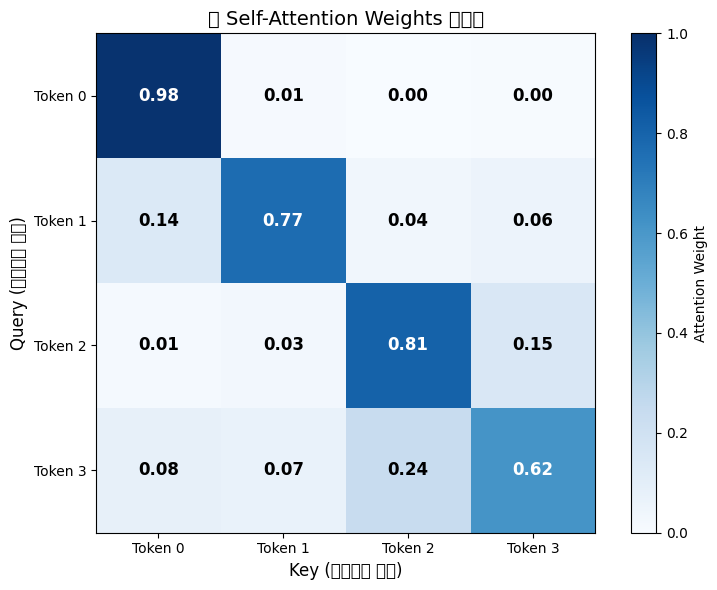


📖 그래프 해석 방법:

  • 행(Row) = Query: 정보를 요청하는 토큰
  • 열(Column) = Key: 참조되는 토큰
  • 값 = 참조 비율 (0~1, 각 행의 합 = 1)

  예시: weights[1][0] = 0.30이면
        → 'Token 1이 Token 0을 30% 비율로 참조한다'

🔗 Decision Transformer에서는:
   현재 상태가 과거의 여러 상태들을 얼마나 참조할지 결정!


In [12]:
# ============================================================================
# 📊 Attention Weights 시각화
# ============================================================================
#
# Attention weights를 히트맵으로 시각화합니다.
# 색이 진할수록 더 많이 참조한다는 의미입니다.
#
# ============================================================================

plt.figure(figsize=(8, 6))

# 히트맵 그리기
im = plt.imshow(weights.detach().numpy(), cmap='Blues', vmin=0, vmax=1)
plt.colorbar(im, label='Attention Weight')

# 레이블 설정
plt.xlabel('Key (참조되는 토큰)', fontsize=12)
plt.ylabel('Query (참조하는 토큰)', fontsize=12)
plt.title('🧠 Self-Attention Weights 시각화', fontsize=14)

# 축 눈금
tokens = ['Token 0', 'Token 1', 'Token 2', 'Token 3']
plt.xticks(range(4), tokens)
plt.yticks(range(4), tokens)

# 각 셀에 값 표시
for i in range(4):
    for j in range(4):
        color = 'white' if weights[i,j] > 0.5 else 'black'
        plt.text(j, i, f'{weights[i,j]:.2f}', ha='center', va='center', 
                fontsize=12, color=color, fontweight='bold')

plt.tight_layout()
plt.show()

# 해석 설명
print()
print("📖 그래프 해석 방법:")
print("=" * 60)
print()
print("  • 행(Row) = Query: 정보를 요청하는 토큰")
print("  • 열(Column) = Key: 참조되는 토큰")
print("  • 값 = 참조 비율 (0~1, 각 행의 합 = 1)")
print()
print("  예시: weights[1][0] = 0.30이면")
print("        → 'Token 1이 Token 0을 30% 비율로 참조한다'")
print()
print("🔗 Decision Transformer에서는:")
print("   현재 상태가 과거의 여러 상태들을 얼마나 참조할지 결정!")

---

## 2.2 Causal Masking (인과적 마스킹)

### 📖 Causal Masking이란?

GPT 같은 **Autoregressive(자기회귀) 모델**에서는 **미래 정보를 볼 수 없어야** 합니다.

> 💡 **비유**: 시험 문제를 순서대로 풀 때, 아직 안 푼 뒷 문제의 답을 미리 볼 수 없는 것과 같습니다.

### 🔒 왜 필요한가?

```mermaid
flowchart TB
    Sentence["📝 문장: The cat sat on the ___"]

    subgraph Bad["❌ 일반 Attention"]
        B1["'on' 예측 시<br/>미래 토큰도 참조"] --> B2["치팅!<br/>학습 실패 😱"]
    end

    subgraph Good["✅ Causal Attention"]
        G1["'on' 예측 시<br/>과거만 참조<br/>(The, cat, sat)"] --> G2["정상 학습!<br/>성공 🎉"]
    end

    Sentence --> Bad
    Sentence --> Good

    style Bad fill:#ffebee,stroke:#c62828
    style Good fill:#e8f5e9,stroke:#2e7d32
    style B2 fill:#ffcdd2
    style G2 fill:#c8e6c9
```

### 🔢 Causal Mask 구조

Causal Mask는 **하삼각 행렬**입니다:

|  | Token 0 | Token 1 | Token 2 | Token 3 |
|:---:|:---:|:---:|:---:|:---:|
| **Token 0** | ✅ 1 | ❌ 0 | ❌ 0 | ❌ 0 |
| **Token 1** | ✅ 1 | ✅ 1 | ❌ 0 | ❌ 0 |
| **Token 2** | ✅ 1 | ✅ 1 | ✅ 1 | ❌ 0 |
| **Token 3** | ✅ 1 | ✅ 1 | ✅ 1 | ✅ 1 |

- **1 = 볼 수 있음**: 자기 자신과 이전 토큰들
- **0 = 볼 수 없음**: 미래 토큰들 (마스킹됨)

아래 코드에서 구현하고 비교해봅시다! 👇

In [13]:
# ============================================================================
# 🔒 Causal Self-Attention 구현하기
# ============================================================================
#
# 미래 토큰을 볼 수 없도록 마스킹을 적용합니다.
# 마스킹된 위치는 attention score가 -∞가 되어 softmax 후 0이 됩니다.
#
# ============================================================================

def causal_self_attention(x):
    """
    Causal (Masked) Self-Attention 구현
    
    핵심: 미래 토큰의 attention score를 -∞로 만들어서
          softmax 후 0이 되게 합니다.
    
    Args:
        x: 입력 텐서 (seq_len, d_model)
    
    Returns:
        output: Attention 결과
        attention_weights: 마스킹이 적용된 attention weights
        mask: 사용된 causal mask
    """
    seq_len = x.shape[0]
    d_k = x.shape[-1]
    
    Q, K, V = x, x, x
    
    # ─────────────────────────────────────────────────────────
    # Step 1: Attention scores 계산
    # ─────────────────────────────────────────────────────────
    scores = torch.matmul(Q, K.T) / (d_k ** 0.5)
    
    # ─────────────────────────────────────────────────────────
    # Step 2: Causal Mask 생성 (하삼각 행렬)
    # ─────────────────────────────────────────────────────────
    # torch.tril = 하삼각 행렬 (lower triangular)
    mask = torch.tril(torch.ones(seq_len, seq_len))
    
    # ─────────────────────────────────────────────────────────
    # Step 3: 마스크 적용 (미래 위치는 -∞로)
    # ─────────────────────────────────────────────────────────
    # mask == 0인 위치(미래)를 -∞로 설정
    # softmax(-∞) = 0이 됨!
    scores = scores.masked_fill(mask == 0, float('-inf'))
    
    # ─────────────────────────────────────────────────────────
    # Step 4: Softmax 적용
    # ─────────────────────────────────────────────────────────
    attention_weights = F.softmax(scores, dim=-1)
    
    # ─────────────────────────────────────────────────────────
    # Step 5: Value의 가중합
    # ─────────────────────────────────────────────────────────
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights, mask

# ============================================================================
# 🧪 테스트하기
# ============================================================================

x = torch.randn(4, 8)
output, causal_weights, mask = causal_self_attention(x)

print("=" * 60)
print("🔒 Causal Mask")
print("=" * 60)
print()
print("1 = 볼 수 있음, 0 = 볼 수 없음 (마스킹)")
print()
print(mask)
print()

print("=" * 60)
print("📊 Causal Attention Weights")
print("=" * 60)
print()
print("상삼각 부분(미래)이 모두 0인 것을 확인하세요!")
print()

# 행렬 출력
print("        ", end="")
for j in range(4):
    print(f"  토큰{j}  ", end="")
print()
print("       +" + "-" * 36 + "+")

for i in range(4):
    print(f"토큰{i}  |", end="")
    for j in range(4):
        val = causal_weights[i,j].item()
        if val == 0:
            print(f"   --   ", end="")  # 마스킹된 부분
        else:
            print(f"  {val:.2f}  ", end="")
    print(f"| = {causal_weights[i].sum():.2f}")

print("       +" + "-" * 36 + "+")
print()
print("💡 '--'로 표시된 부분: 미래 토큰 (볼 수 없음)")

🔒 Causal Mask

1 = 볼 수 있음, 0 = 볼 수 없음 (마스킹)

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

📊 Causal Attention Weights

상삼각 부분(미래)이 모두 0인 것을 확인하세요!

          토큰0    토큰1    토큰2    토큰3  
       +------------------------------------+
토큰0  |  1.00     --      --      --   | = 1.00
토큰1  |  0.01    0.99     --      --   | = 1.00
토큰2  |  0.18    0.44    0.37     --   | = 1.00
토큰3  |  0.03    0.26    0.09    0.62  | = 1.00
       +------------------------------------+

💡 '--'로 표시된 부분: 미래 토큰 (볼 수 없음)


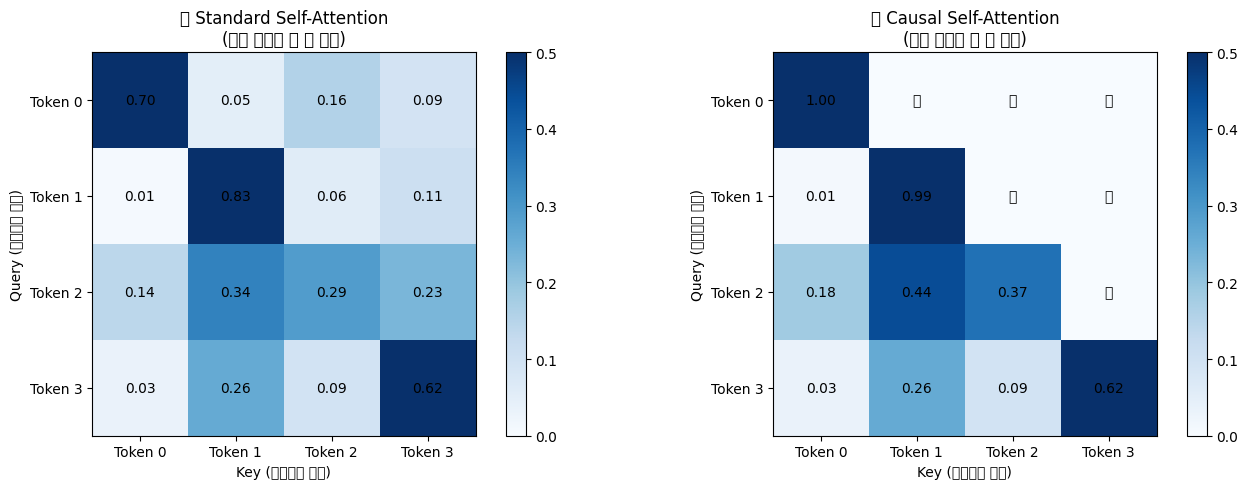


📖 두 방식의 차이

  Standard Attention:
    • 모든 토큰이 서로를 볼 수 있음
    • 문장 분류, 번역의 인코더 등에서 사용

  Causal Attention:
    • 각 토큰은 자신과 이전 토큰만 볼 수 있음
    • GPT, Decision Transformer 등에서 사용

🔗 Decision Transformer에서:
   현재 시점에서 미래의 상태/행동을 볼 수 없도록 마스킹!


In [14]:
# ============================================================================
# 📊 Standard vs Causal Attention 비교 시각화
# ============================================================================
#
# 두 가지 Attention 방식의 차이를 나란히 비교합니다.
# 핵심 차이: Causal Attention은 상삼각 부분이 0!
#
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ─────────────────────────────────────────────────────────
# 왼쪽: Standard (Full) Attention
# ─────────────────────────────────────────────────────────
_, standard_weights = simple_self_attention(x)

im1 = axes[0].imshow(standard_weights.detach().numpy(), cmap='Blues', vmin=0, vmax=0.5)
axes[0].set_title('📊 Standard Self-Attention\n(모든 토큰을 볼 수 있음)', fontsize=12)
axes[0].set_xlabel('Key (참조되는 토큰)')
axes[0].set_ylabel('Query (참조하는 토큰)')
plt.colorbar(im1, ax=axes[0])

# 값 표시
for i in range(4):
    for j in range(4):
        axes[0].text(j, i, f'{standard_weights[i,j]:.2f}', ha='center', va='center', fontsize=10)

# ─────────────────────────────────────────────────────────
# 오른쪽: Causal Attention
# ─────────────────────────────────────────────────────────
im2 = axes[1].imshow(causal_weights.detach().numpy(), cmap='Blues', vmin=0, vmax=0.5)
axes[1].set_title('🔒 Causal Self-Attention\n(미래 토큰은 볼 수 없음)', fontsize=12)
axes[1].set_xlabel('Key (참조되는 토큰)')
axes[1].set_ylabel('Query (참조하는 토큰)')
plt.colorbar(im2, ax=axes[1])

# 값 표시
for i in range(4):
    for j in range(4):
        val = causal_weights[i,j].item()
        text = f'{val:.2f}' if val > 0 else '🚫'
        axes[1].text(j, i, text, ha='center', va='center', fontsize=10)

# 축 레이블
for ax in axes:
    ax.set_xticks(range(4))
    ax.set_yticks(range(4))
    ax.set_xticklabels([f'Token {i}' for i in range(4)])
    ax.set_yticklabels([f'Token {i}' for i in range(4)])

plt.tight_layout()
plt.show()

# 해석 설명
print()
print("=" * 60)
print("📖 두 방식의 차이")
print("=" * 60)
print()
print("  Standard Attention:")
print("    • 모든 토큰이 서로를 볼 수 있음")
print("    • 문장 분류, 번역의 인코더 등에서 사용")
print()
print("  Causal Attention:")
print("    • 각 토큰은 자신과 이전 토큰만 볼 수 있음")
print("    • GPT, Decision Transformer 등에서 사용")
print()
print("🔗 Decision Transformer에서:")
print("   현재 시점에서 미래의 상태/행동을 볼 수 없도록 마스킹!")

---

## 2.3 Positional Encoding (위치 인코딩)

### 📖 왜 위치 정보가 필요한가?

Transformer의 Attention은 **순서를 모릅니다**! 입력 순서를 바꿔도 같은 결과가 나옵니다.

```mermaid
flowchart TB
    subgraph Input["📝 두 가지 입력"]
        I1["입력1: 고양이가, 쥐를, 잡았다"]
        I2["입력2: 쥐를, 고양이가, 잡았다"]
    end

    subgraph NoPos["❌ Attention만 사용"]
        NP["두 입력이 같게 처리됨!<br/><small>순서 정보 없음</small>"]
    end

    subgraph WithPos["✅ + Positional Encoding"]
        WP["각 단어에 위치 정보 추가<br/><small>1번째, 2번째, 3번째...</small>"]
        WR["순서가 다르면 다르게 처리!"]
        WP --> WR
    end

    Input --> NoPos
    Input --> WithPos

    style NoPos fill:#ffebee,stroke:#c62828
    style WithPos fill:#e8f5e9,stroke:#2e7d32
    style NP fill:#ffcdd2
    style WR fill:#c8e6c9
```

### 🔢 두 가지 방식

| 방식 | 설명 | 특징 | 사용 모델 |
|:---:|:---|:---|:---:|
| **Sinusoidal** | sin/cos 함수로 고정 패턴 생성 | 학습 불필요, 긴 시퀀스 일반화 가능 | 원본 Transformer |
| **Learned** | 각 위치마다 학습 가능한 벡터 | 데이터에서 최적 패턴 학습 | **GPT, DT** |

### 💡 Decision Transformer에서의 사용

> Decision Transformer는 **Learned Positional Embedding**을 사용합니다.
> 하지만 일반적인 "시퀀스 내 위치"가 아니라 **timestep(시간 단계)**을 임베딩합니다!

아래 코드에서 두 방식을 모두 구현해봅시다! 👇

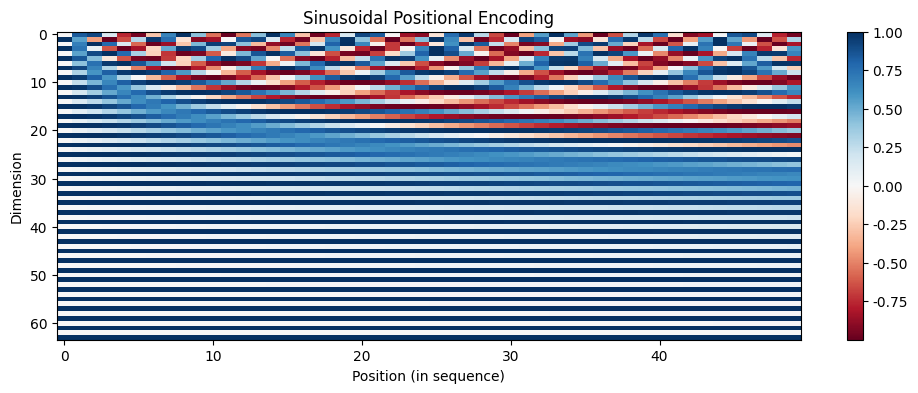

In [15]:
import math

def sinusoidal_positional_encoding(seq_len, d_model):
    """
    Sinusoidal positional encoding ("Attention Is All You Need" paper)
    """
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len).unsqueeze(1).float()
    
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                         (-math.log(10000.0) / d_model))
    
    pe[:, 0::2] = torch.sin(position * div_term)  # even dimensions
    pe[:, 1::2] = torch.cos(position * div_term)  # odd dimensions
    
    return pe

# 시각화
pe = sinusoidal_positional_encoding(50, 64)

plt.figure(figsize=(12, 4))
plt.imshow(pe.T, aspect='auto', cmap='RdBu')
plt.colorbar()
plt.xlabel('Position (in sequence)')
plt.ylabel('Dimension')
plt.title('Sinusoidal Positional Encoding')
plt.show()

In [16]:
# Learned Positional Embedding (GPT 스타일)
import torch.nn as nn

class LearnedPositionalEmbedding(nn.Module):
    def __init__(self, max_seq_len, d_model):
        """
        Args:
            max_seq_len: 처리할 수 있는 최대 시퀀스 길이 (용량)
            d_model: 임베딩 차원
        """
        super().__init__()
        # 학습 가능한 임베딩 벡터
        # nn.Embedding(100, 64) → 100개 위치 × 64차원의 테이블 생성
        self.pos_embedding = nn.Embedding(max_seq_len, d_model)

    def forward(self, x):
        seq_len = x.shape[0]  # 실제 입력 길이
        positions = torch.arange(seq_len)  # [0, 1, 2, ..., seq_len-1]
        return self.pos_embedding(positions)

# 테스트
# ┌─────────────────────────────────────────────────────────────────┐
# │ LearnedPositionalEmbedding(100, 64) 파라미터 설명:              │
# │                                                                 │
# │  100 = max_seq_len (최대 용량)                                  │
# │      → "최대 100개 위치까지 처리할 수 있는 임베딩 테이블"       │
# │      → 내부적으로 (100 × 64) 크기의 학습 가능한 행렬 생성       │
# │                                                                 │
# │  64 = d_model (임베딩 차원)                                     │
# │      → 각 위치는 64차원 벡터로 표현됨                           │
# │                                                                 │
# │  x = torch.randn(10, 64)                                        │
# │      → 10 = 현재 입력 시퀀스 길이 (테스트용)                    │
# │      → 100개 중 10개 위치만 실제로 사용                         │
# │                                                                 │
# │  비유: 100칸짜리 주차장에 10대만 주차한 상황                    │
# │      - 주차장 용량: 100칸 (max_seq_len)                         │
# │      - 현재 주차된 차: 10대 (실제 입력 길이)                    │
# └─────────────────────────────────────────────────────────────────┘
pos_emb = LearnedPositionalEmbedding(100, 64)  # 최대 100 위치, 각 64차원
x = torch.randn(10, 64)  # 실제로는 10개 토큰만 테스트
pe = pos_emb(x)

print(f"입력 shape: {x.shape}")
print(f"Position embedding shape: {pe.shape}")
print(f"\n최종 입력 = 토큰 임베딩 + 위치 임베딩")
print(f"(x + pe).shape = {(x + pe).shape}")

입력 shape: torch.Size([10, 64])
Position embedding shape: torch.Size([10, 64])

최종 입력 = 토큰 임베딩 + 위치 임베딩
(x + pe).shape = torch.Size([10, 64])


### 2.4 GPT의 Autoregressive 생성

GPT는 이전 토큰들을 보고 다음 토큰을 예측합니다.

```
입력: [<start>, The, cat, sat]
예측: [  The,   cat, sat,  on]
```

In [ ]:
# 간단한 Autoregressive 생성 시뮬레이션
vocab = ['<start>', 'the', 'cat', 'sat', 'on', 'mat', '<end>']

# 가상의 다음 토큰 확률 (실제로는 모델이 예측)
fake_next_token_probs = {
    '<start>': {'the': 0.9, 'cat': 0.05, 'sat': 0.05},
    'the': {'cat': 0.7, 'mat': 0.3},
    'cat': {'sat': 0.9, 'on': 0.1},
    'sat': {'on': 0.95, '<end>': 0.05},
    'on': {'the': 0.3, 'mat': 0.7},
    'mat': {'<end>': 1.0},
}

def generate_sequence(start_token='<start>', max_len=10):
    sequence = [start_token]
    current = start_token
    
    for _ in range(max_len):
        if current not in fake_next_token_probs:
            break
            
        probs = fake_next_token_probs[current]
        tokens = list(probs.keys())
        probabilities = list(probs.values())
        
        # 확률적 샘플링
        next_token = np.random.choice(tokens, p=probabilities)
        sequence.append(next_token)
        current = next_token
        
        if next_token == '<end>':
            break
    
    return sequence

# 여러 문장 생성
print("Autoregressive 생성 예시:")
for i in range(5):
    seq = generate_sequence()
    print(f"  {i+1}. {' '.join(seq)}")

---
## 3. 연습 문제

### 연습 1: Return 계산

다음 rewards가 주어졌을 때, 각 timestep에서의 Return을 계산하세요.

In [ ]:
rewards = [2, 4, 1, 3, 5]

# TODO: 각 timestep에서의 Return 계산 (γ=1)
# returns[0] = 2 + 4 + 1 + 3 + 5 = ?
# returns[1] = 4 + 1 + 3 + 5 = ?
# ...

returns = []
for i in range(len(rewards)):
    # 여기에 코드 작성
    pass

# 정답 확인
# print(f"Returns: {returns}")
# 예상: [15, 13, 9, 8, 5]

<details>
<summary>정답 보기</summary>

```python
returns = []
for i in range(len(rewards)):
    returns.append(sum(rewards[i:]))

print(f"Returns: {returns}")  # [15, 13, 9, 8, 5]
```
</details>

### 연습 2: Causal Mask 이해

5개의 토큰이 있을 때, 3번째 토큰(인덱스 2)은 어떤 토큰들을 참조할 수 있나요?

In [ ]:
# TODO: 5x5 causal mask 만들기
seq_len = 5
# mask = ?

# 정답 확인
# print(mask)
# print(f"\n토큰 2가 참조할 수 있는 토큰: {?}")

<details>
<summary>정답 보기</summary>

```python
mask = torch.tril(torch.ones(5, 5))
print(mask)
# tensor([[1., 0., 0., 0., 0.],
#         [1., 1., 0., 0., 0.],
#         [1., 1., 1., 0., 0.],  ← 토큰 2: 0, 1, 2 참조 가능
#         [1., 1., 1., 1., 0.],
#         [1., 1., 1., 1., 1.]])

print(f"토큰 2가 참조할 수 있는 토큰: 0, 1, 2 (자기 자신까지)")
```
</details>

### 연습 3: Policy 구현

상태가 목표(5)에 가까울수록 오른쪽으로 갈 확률이 높은 policy를 구현하세요.

In [ ]:
def smart_policy(state):
    """
    state가 5에 가까울수록 오른쪽(1)으로 갈 확률 증가
    state가 0에 가까울수록 왼쪽(0)으로 갈 확률 증가
    """
    # TODO: 구현
    pass

# 테스트
# for s in range(6):
#     actions = [smart_policy(s) for _ in range(100)]
#     right_prob = sum(actions) / 100
#     print(f"State {s}: 오른쪽 확률 = {right_prob:.2f}")

<details>
<summary>정답 보기</summary>

```python
def smart_policy(state):
    # state가 클수록 오른쪽 확률 높음
    prob_right = state / 5.0  # 0~1 사이 값
    return 1 if np.random.random() < prob_right else 0

# 또는 더 간단하게:
def smart_policy_v2(state):
    return 1 if state < 5 else 0  # 목표에 도달하면 멈춤
```
</details>

---

# 🎉 Phase 1 완료!

## 📚 배운 내용 요약

### 🎮 강화학습 기초
| 개념 | 설명 |
|:---:|:---|
| **State** | 환경의 현재 상태 |
| **Action** | 에이전트가 취하는 행동 |
| **Reward** | 행동의 결과로 받는 피드백 |
| **Policy** | 상태에서 행동을 선택하는 규칙 |
| **Return** | 에피소드의 총 보상 |
| **Trajectory** | (s, a, r) 시퀀스 - DT의 입력 데이터! |

### 🤖 Transformer 기초
| 개념 | 설명 | DT에서의 역할 |
|:---:|:---|:---|
| **Self-Attention** | 시퀀스 내 관계 파악 | 과거 상태/행동 참조 |
| **Causal Masking** | 미래 정보 차단 | 시간 순서 유지 |
| **Positional Encoding** | 위치 정보 제공 | timestep 구분 |

---

## ➡️ 다음 단계

**Phase 2: Decision Transformer 핵심 개념** → `phase2_core_concepts.ipynb`

- Return-to-Go (RTG) 개념
- 시퀀스 구성 방식 (R, s, a)
- 기존 RL과의 차이점

---

## ✅ 체크리스트

다음으로 넘어가기 전에 확인하세요:

- [ ] State, Action, Reward 개념을 설명할 수 있다
- [ ] Return과 Discount factor를 계산할 수 있다
- [ ] Policy가 무엇인지 이해했다
- [ ] Trajectory가 DT에서 어떻게 사용되는지 이해했다
- [ ] Self-Attention의 Q, K, V 개념을 이해했다
- [ ] Causal Masking이 왜 필요한지 이해했다
- [ ] Positional Encoding의 역할을 이해했다